# Machine Learning Project

## Binary classification based on 3 layers neural network (3)

#### First layer

$Z^{[1]} = W^{[1]} X + b^{[1]}$ : $X$ denotes the input data

$A^{[1]} = g^{[1]}(Z^{[1]})$ : $g^{[1]}$ is the activation function at the first layer

#### Second layer

$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$

$A^{[2]} = g^{[2]}(Z^{[2]})$ : $g^{[2]}$ is the activation function at the second layer

#### Third layer

$Z^{[3]} = W^{[3]} A^{[2]} + b^{[3]}$

$A^{[3]} = g^{[3]}(Z^{[3]})$ : $g^{[3]}$ is the activation function at the third (output) layer

### Activation Function

- Sigmoid

    $g(z) = \frac{1}{1 + \exp^{-z}}$
## Loss function with a regularization term based on $L_2^2$ norm

$\mathcal{L} = \frac{1}{n} \sum_{i=1}^n f_i + \frac{\lambda}{2} \left( \| W^{[1]} \|_F^2 + \| W^{[2]} \|_F^2 + \| W^{[3]} \|_F^2 \right)$

- Cross Entropy : 
    $f_i = - y_i \log \hat{y}_i - (1 - y_i) \log (1 - \hat{y}_i) $

- Frobenius Norm : 
    $\| W \|_F = \left( \sum_i \sum_j w_{ij}^2 \right)^{\frac{1}{2}}$

### Dataset

- The dataset consists of human images and horse images for the training and the validation
- The classifier should be trained using only the training set
- The classifier should be tested using only the validation set
- Vectorize an input image matrix into a column vector

### Implementation

- Write codes in python programming
- Use jupyter notebook for the programming environment
- You can use any libarary
- You have to write your own functions for the followings:
    - compute the forward propagation
    - compute the backward propagation
    - compute the loss
    - compute the accuracy
    - compute the gradient of the model parameters with respect to the loss
    - update the model parameters
    - plot the results

### Optimization

- You should apply the full gradient descent algorithm with your choice of learning rates
- You should apply enough number of iterations that lead to the convergence of the algorithm
- You should use the vectorization scheme in the computation of gradients and the update of the model parameters
- You can initialize the model parameters with your own algorithm

### [ Implementation ]

#### (1) Libraries and Global variables

In [5]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import math
import os

# Global Variables
train_data_path = './horse-or-human/train'
validation_data_path = './horse-or-human/validation'

layer_dims = [10000,50,10,1]    # number of units(Neurons) in each layer
learning_rate = 0.02            # step size per each epoch (iteration)
threshold = 0.1                 # minimum of cost
max_epoch = 2500                # maximum number of epoch (iteration)

#### (2) Generate Input matrix X and Output vector Y from training and validation datasets

In [6]:
def initialize_inputs(image_path) :
    transform = transforms.Compose([transforms.Grayscale(),transforms.ToTensor(),])
    # the code transforms.Grayscale() is for changing the size [3,100,100] to [1, 100, 100]
    # (notice : [channel, height, width] )
    image_set = torchvision.datasets.ImageFolder(root=image_path, transform=transform)
    loader = torch.utils.data.DataLoader(image_set, batch_size=1, shuffle=False, num_workers=1)  

    for i,data in enumerate(loader) :
        image, label = data
        image = image.view(10000,1)
        label = label.view(1,1).type(torch.FloatTensor)
        
        if i == 0 :
            t_images = image
            t_labels = label
        else :
            t_images = torch.cat((t_images,image),dim = 1)
            t_labels = torch.cat((t_labels,label),dim = 1)
        
        images = t_images.numpy()
        labels = t_labels.numpy()
    
    return images, labels

#### (3) Activation Functions

In [7]:
def Sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A

def Sigmoid_backward(dA, Z):
    t_A = 1/(1+np.exp(-Z))
    dZ = dA * t_A * (1-t_A)
    return dZ

def ReLU(Z):
    A = np.maximum(0,Z)
    return A

def ReLU_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0    
    return dZ

def Leaky_ReLU(Z) :
    A = np.maximum(0.01*Z, Z)
    return A

def Leaky_ReLU_backward(dA,Z) :
    dZ = np.array(dA, copy=True)
    dZ[Z < 0] *= 0.01
    return dZ
    
def Tanh(Z) :
    A = np.tanh(Z)
    return A

def Tanh_backward(dA, Z) :
    t_A = np.tanh(Z)
    dZ = dA * (1 - np.square(t_A))
    return dZ

#### (4) Cost and Parameter initialization / update Functions

In [54]:
def initalize_parameters(n) :
    parameters = dict()
    
    # Initalize W[i] and b[i] for i in [1,L-1]
    for l in range(1,len(n)) :
        parameters['W'+str(l)] = np.random.randn(n[l],n[l-1]) / np.sqrt(n[l-1])
        parameters['b'+str(l)] = np.zeros((n[l],1))
        
    return parameters

def update_parameters(parameters,gradients,learning_rate) :
    L = len(parameters) // 2
    
    # Update W[i] and b[i] for i in [1,L]
    for l in range(1,L+1) :
        dW, db = gradients['dW'+str(l)], gradients['db'+str(l)]
        parameters['W'+str(l)] -= learning_rate * dW
        parameters['b'+str(l)] -= learning_rate * db

    return parameters

def cost_computation(AL, Y, parameters, mbd) :
    reg = 0
    L = len(parameters) // 2
    m = Y.shape[1]
    
    for l in range(1,L+1) :
        reg += np.sum(np.square(parameters['W'+str(l)]))
    reg *= mbd / (2 * m)
    
    cost = (-np.dot(Y,np.log(AL).T) - np.dot(1-Y,np.log(1-AL).T)) / m + reg
    
    cost = np.squeeze(cost)
    return cost

#### (5) Forward Propagation

In [9]:
def forward_Z_computation(A_prev,W,b) :
    Z = np.dot(W,A_prev) + b
    return Z

def forward_A_computation(A_prev,W,b,activation) :
    assert activation in ['sigmoid','relu','tanh','leaky_relu']
    
    Z = forward_Z_computation(A_prev,W,b)
    if activation == 'sigmoid' :
        A = Sigmoid(Z)
    elif activation == 'relu' :
        A = ReLU(Z)
    elif activation == 'tanh' :
        A = Tanh(Z)
    else :
        A = Leaky_ReLU(Z)
    
    cache = ((A_prev,W,b),Z)
    return A, cache

def forward_propagation(X,parameters,activations) :
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1,L+1) :
        A_prev, W, b = A, parameters['W'+str(l)], parameters['b'+str(l)]
        A,cache = forward_A_computation(A_prev,W,b,activations[l-1])
        caches.append(cache)    
    AL = A
    
    return AL, caches

#### (6) Backward Propagation

In [16]:
def backward_params_dev_computation(dA,cache,activation, mbd) :
    assert activation in ['sigmoid','relu','tanh','leaky_relu']
    (A_prev,W,b),Z = cache
    m = A_prev.shape[1]

    if activation == 'sigmoid' :
        dZ = Sigmoid_backward(dA,Z)
    elif activation == 'relu' :
        dZ = ReLU_backward(dA,Z)
    elif activation == 'tanh' :
        dZ = Tanh_backward(dA,Z)
    else :
        dZ = Leaky_ReLU_backward(dA,Z)
    
#    dW = np.dot(dZ,A_prev.T) / m
    dW = np.dot(dZ,A_prev.T) / m + mbd / m * W
    db = np.sum(dZ, axis = 1, keepdims = True) / m
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db azuu

def backward_propagation(AL, Y, caches,activations, mbd) :
    gradients = dict()
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y,AL) - np.divide(1-Y,1-AL))
    cache = caches[L-1]
    dA_prev, dW, db = backward_params_dev_computation(dAL,cache,activations[L-1], mbd)
    gradients['dA'+str(L)] = dA_prev
    gradients['dW'+str(L)] = dW
    gradients['db'+str(L)] = db
    
    for l in reversed(range(1,L)) :
        dA = gradients['dA' + str(l+1)]
        dA_prev, dW, db = backward_params_dev_computation(dA,caches[l-1],activations[l-1], mbd)
        gradients['dA'+str(l)] = dA_prev
        gradients['dW'+str(l)] = dW
        gradients['db'+str(l)] = db
        
    return gradients

#### (7) Predictions

In [17]:
def predict(AL,Y) :
    correct = np.zeros(Y.shape)
    m = AL.shape[1]

    prediction = AL > 0.5
    correct = prediction == Y
    
    accuracy = np.sum(correct) / m
    return accuracy

#### (8) 3-layer Neural Network

In [26]:
def NN_3_layers(X,Y,t_X,t_Y,n,activations,mbd,learning_rate,threshold,max_epoch) :

    np.random.seed(1)
    costs, t_costs = [],[]
    accuracy, t_accuracy = [],[]
    parameters = initalize_parameters(n)
    
    for epoch in range(max_epoch) :
        AL, caches = forward_propagation(X, parameters, activations)
        t_AL, _t = forward_propagation(t_X, parameters, activations)
        
        cost = cost_computation(AL,Y,parameters,mbd)
        t_cost = cost_computation(t_AL,t_Y,parameters,mbd)
        
        gradients = backward_propagation(AL,Y,caches,activations,mbd)
        
        parameters = update_parameters(parameters,gradients,learning_rate)
        
        costs.append(cost)
        t_costs.append(t_cost)
        
        accuracy.append(predict(AL,Y))
        t_accuracy.append(predict(t_AL,t_Y))
        
        if  epoch % 100 == 0:
            print ("Cost after iteration %i: %f" %(epoch, cost))
        if cost < threshold :
            break
            
    return costs, accuracy, t_costs, t_accuracy

#### (9) Plot Loss and Accuracy Graphs

In [19]:
def plotResult(costs,accuracy,title) :
    plt.rcParams["figure.figsize"] = (12,6)
    plt.subplot(121)
    plt.title('Costs', fontsize = 15, color = 'black')
    plt.plot(np.squeeze(costs))
    plt.subplot(122)
    plt.title('Accuracy', fontsize = 15, color = 'black')
    plt.plot(np.squeeze(accuracy))
    plt.suptitle(title, fontsize = 20, color = 'black',position=(0.5, 1.0+0.05))
    plt.show()

### Output

- Do not print out text message per each iteration. It should be illustrated by graphs
- Demonstrate the role of regularization with varying parameter $\lambda$ for the tradeoff between bias and variance
- Plot the training loss at every iteration (x-axis: iteration, y-axis: loss)
- Plot the validation loss at every iteration (x-axis: iteration, y-axis: loss)
- Plot the training accuracy at every iteration (x-axis: iteration, y-axis: accuracy)
- Plot the validation accuracy at every iteration (x-axis: iteration, y-axis: accuracy)
- Present the table for the final accuracy and loss at convergence with training and validation datasets
    - training loss (at convergence)
    - validation loss (at convergence)
    - training accuracy (at convergence)
    - validation accuracy (at convergence)

In [20]:
X,Y = initialize_inputs(train_data_path)
t_X, t_Y = initialize_inputs(validation_data_path)

n = [10000,50,10,1]

##### Bias (large $\lambda$)

- Learning curves
- Loss and Accuracy table 

| dataset    | loss       | accuracy   | 
|:----------:|:----------:|:----------:|
| training   |            |            |
| validation |            |            |

In [37]:
activations = ['sigmoid','sigmoid','sigmoid']
learning_rate = 0.03
thres_hold = 0.01
max_epoch = 3000
mbd = 0.1

costs, accuracy, t_costs, t_accuracy = NN_3_layers(X,Y,t_X,t_Y,n,activations,mbd,learning_rate,threshold,max_epoch)

Cost after iteration 0: 0.779455
Cost after iteration 100: 0.696083
Cost after iteration 200: 0.687032
Cost after iteration 300: 0.677831
Cost after iteration 400: 0.665737
Cost after iteration 500: 0.648542
Cost after iteration 600: 0.624929
Cost after iteration 700: 0.595123
Cost after iteration 800: 0.561172
Cost after iteration 900: 0.525849
Cost after iteration 1000: 0.491228
Cost after iteration 1100: 0.458176
Cost after iteration 1200: 0.426825
Cost after iteration 1300: 0.397099
Cost after iteration 1400: 0.368909
Cost after iteration 1500: 0.342183
Cost after iteration 1600: 0.316928
Cost after iteration 1700: 0.293122
Cost after iteration 1800: 0.270703
Cost after iteration 1900: 0.312731
Cost after iteration 2000: 0.285499
Cost after iteration 2100: 0.269552
Cost after iteration 2200: 0.255447
Cost after iteration 2300: 0.241921
Cost after iteration 2400: 0.228586
Cost after iteration 2500: 0.215286
Cost after iteration 2600: 0.202086
Cost after iteration 2700: 0.189075
Cost

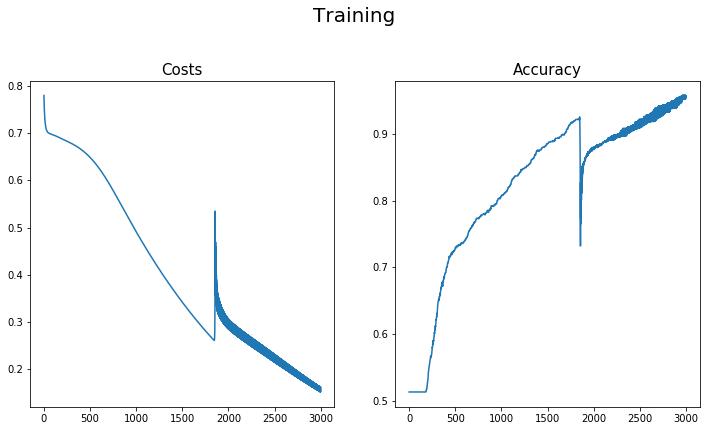

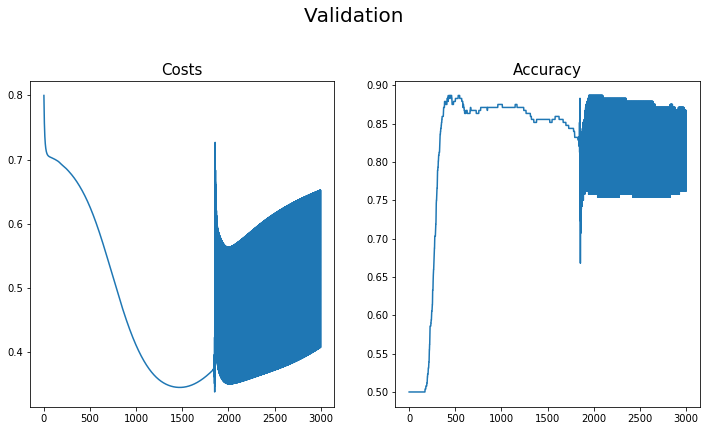

In [38]:
plotResult(costs, accuracy,'Training')
plotResult(t_costs, t_accuracy, 'Validation')

In [39]:
print("Training Loss       : %.5f" % costs[-1])
print("Training Accuracy   : %.2f %%" % (accuracy[-1] * 100))
print("Validation Loss     : %.5f" % t_costs[-1])
print("Validation Accuracy : %.2f %%" % (t_accuracy[-1] * 100))

Training Loss       : 0.16208
Training Accuracy   : 95.42 %
Validation Loss     : 0.40815
Validation Accuracy : 86.72 %


In [40]:
i = t_accuracy.index(max(t_accuracy))
max_validation_cost, max_validation_accuracy = t_costs[i], t_accuracy[i]

print("Max Validation Loss     : %.5f" % max_validation_cost)
print("Max Validation Accuracy : %.2f %%" % (max_validation_accuracy * 100))

Max Validation Loss     : 0.64931
Max Validation Accuracy : 88.67 %


##### Variance (small $\lambda$)

- Learning curves
- Loss and Accuracy table 

| dataset    | loss       | accuracy   | 
|:----------:|:----------:|:----------:|
| training   |            |            |
| validation |            |            |

##### Best Generalization (appropriate $\lambda$)

- Learning curves
- Loss and Accuracy table 

| dataset    | loss       | accuracy   | 
|:----------:|:----------:|:----------:|
| training   |            |            |
| validation |            |            |

In [55]:
activations = ['sigmoid','sigmoid','sigmoid']
learning_rate = 0.01
thres_hold = 0.01
max_epoch = 3000
mbd = 0.001

costs, accuracy, t_costs, t_accuracy = NN_3_layers(X,Y,t_X,t_Y,n,activations,mbd,learning_rate,threshold,max_epoch)

Cost after iteration 0: 0.776573
Cost after iteration 100: 0.693210
Cost after iteration 200: 0.684146
Cost after iteration 300: 0.674903
Cost after iteration 400: 0.662736
Cost after iteration 500: 0.645425
Cost after iteration 600: 0.621654
Cost after iteration 700: 0.591665
Cost after iteration 800: 0.557537
Cost after iteration 900: 0.522061
Cost after iteration 1000: 0.487305
Cost after iteration 1100: 0.454124
Cost after iteration 1200: 0.422646
Cost after iteration 1300: 0.392791
Cost after iteration 1400: 0.364468
Cost after iteration 1500: 0.337608
Cost after iteration 1600: 0.312220
Cost after iteration 1700: 0.288283
Cost after iteration 1800: 0.265732
Cost after iteration 1900: 0.343631
Cost after iteration 2000: 0.302698
Cost after iteration 2100: 0.284154
Cost after iteration 2200: 0.268976
Cost after iteration 2300: 0.254605
Cost after iteration 2400: 0.240266
Cost after iteration 2500: 0.225706
Cost after iteration 2600: 0.211089
Cost after iteration 2700: 0.196563
Cost

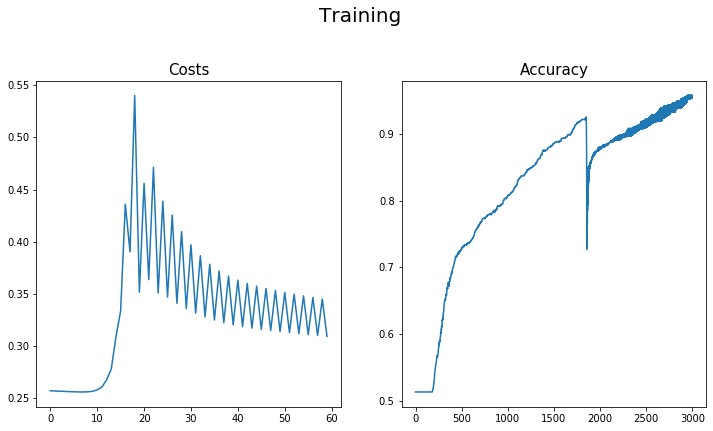

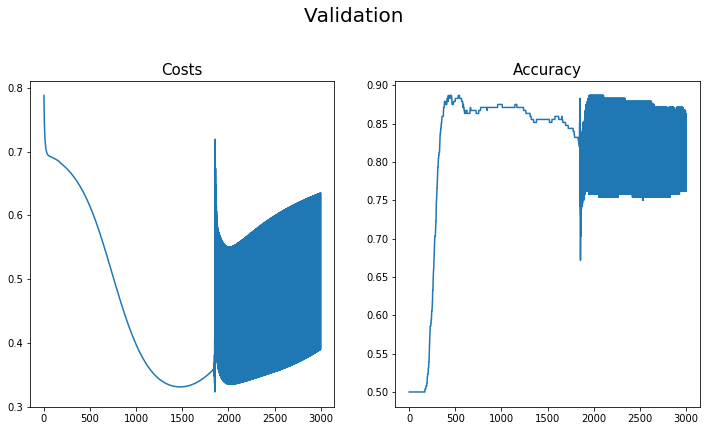

In [63]:
plotResult(costs[1840:1900], accuracy,'Training')
plotResult(t_costs, t_accuracy, 'Validation')

In [57]:
print("Training Loss       : %.5f" % costs[-1])
print("Training Accuracy   : %.2f %%" % (accuracy[-1] * 100))
print("Validation Loss     : %.5f" % t_costs[-1])
print("Validation Accuracy : %.2f %%" % (t_accuracy[-1] * 100))

Training Loss       : 0.14547
Training Accuracy   : 95.81 %
Validation Loss     : 0.63504
Validation Accuracy : 76.17 %


In [58]:
i = t_accuracy.index(max(t_accuracy))
max_validation_cost, max_validation_accuracy = t_costs[i], t_accuracy[i]

print("Max Validation Loss     : %.5f" % max_validation_cost)
print("Max Validation Accuracy : %.2f %%" % (max_validation_accuracy * 100))

Max Validation Loss     : 0.63772
Max Validation Accuracy : 88.67 %


In [59]:
a = np.array(([1,1],[1,1],[1,1]))
print(a)
print(np.linalg.norm(a,ord = 'fro'))


#np.square(np.linalg.norm(parameters['W'+str(l)],ord = 'fro'))

[[1 1]
 [1 1]
 [1 1]]
2.449489742783178
